# Pixel alignment between RGB and depth camera

In [1]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="./images/Pic1.png")

Let's assume that we have the information related to intrinsic parameters of both sensors and also the extrinsic parameters between these two sensors coordinate frame. From perspective pinhole camera projection, we have:

$ \lambda \begin{bmatrix}
u \\
v \\
1 
\end{bmatrix} = \begin{bmatrix}
s_x & s_{\theta} & o_x \\
0 & s_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix} \begin{bmatrix}
f & 0 & 0 \\
0 & f & 0 \\
0 & 0 & 1 \\
\end{bmatrix} \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix} \begin{bmatrix}
R & t \\
0 & 1 \\
\end{bmatrix} \begin{bmatrix}
X_0\\
Y_0 \\
Z_0 \\
1 \end{bmatrix}$

Which: 

$ f $ : focal length of camera in milimeters, 
$ o_x$: x-coordinate of principal point in pixels, 
$ o_y$: y-coordinate of principal point in pixels, 
$ s_x$ : scaling in x-direction to acquire unit length in horizontal pixels, 
$ s_y$ : scaling in y-direction to acquire unit length in horizontal pixels,
$ s_{\theta}$: skew factor ( often close to zero).

In the above equation the $\begin{bmatrix}
X_0\\
Y_0 \\
Z_0 \\
1 \end{bmatrix}$ shows the homogeneous coordinate of a 3D point in the world frame, which if we transfer it to cmaera fram via extrinsic parameters we have: 

$
X_c = \begin{bmatrix}
R & T \\
0 & 1 \\
\end{bmatrix} \begin{bmatrix}
X_0\\
Y_0 \\
Z_0 \\
1 \end{bmatrix}$

In [2]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="./images/Pic2.png")

In our case we consider $s_{\theta} = 0$, also $fs_x = f_x$ and $fs_y = f_y$. Then we have:

$ \lambda \begin{bmatrix}
u_c \\
v_c \\
1 
\end{bmatrix} = \begin{bmatrix}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix}_c \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}  X_c$

In this scenario we will take a pixel location from RGB image and use the projection model to acquire the corrseponding 3D ray in homogeneous coordinate in the RGB camera frame $ X_c $.


Without loosing the generality of equation we can consider $ \lambda = 1 $. 
On the other hand we assumed we have the transformation matrix between two sensors, so we have the below equation for transformation between a homogeneous point in RGB camera and the same point in depth camera frame:

$ 
X_c = T_{d2c}  X_d 
$



In [3]:
from IPython.display import Image
  
# get the image
Image(url="./images/Pic3.png")

Therefore, by substituting $X_c $ in the projection equation, we have:

$ \begin{bmatrix}
u_c \\
v_c \\
1 
\end{bmatrix} = \begin{bmatrix}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix}_c \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}  T_{d2c}  X_d  $

If we use the projection equation for depth camera we have: 

$\lambda_{d} \begin{bmatrix}
u_d \\
v_d \\
1 
\end{bmatrix} = \begin{bmatrix}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix}_d \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix} X_d  $

=> $(\begin{bmatrix}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix}_d \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix})^{-1} \lambda_{d} \begin{bmatrix}
u_d \\
v_d \\
1 
\end{bmatrix} = 
 X_d  $

By substituting $ X_d $ we have: 

$ \begin{bmatrix}
u_c \\
v_c \\
1 
\end{bmatrix} = \begin{bmatrix}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix}_c \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}  T_{d2c} (\begin{bmatrix}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix}_d \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix})^{-1} \lambda_{d} \begin{bmatrix}
u_d \\
v_d \\
1 
\end{bmatrix} $

The this way we can submit a relation between pixel location in RGB and find the corresponding one in depth image.

In [4]:
import cv2 
import numpy as np
from scipy.ndimage.filters import minimum_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os

# Distortion Coefficients and Correction:
In the above derivations we assumed that the images are undistorted. But in real life, it is not the case. So in the first step we will attempt to undistort the images.

In [5]:
Image(url="./images/distortion.png")

We mathematically model the distortion effect based on the lens properties and combine it with the pinhole camera model that is explained in the previous parts. So along with intrinsic and extrinsic parameters discussed earlier, we also have distortion coefficients (which mathematically represent the lens distortion), as additional intrinsic parameters.

To consider these distortions in our camera model we modify the pinhole camera model as follows :

$$
\begin{equation*} \begin{bmatrix}  X_c\\  Y_c\\  Z_c  \end{bmatrix}=\begin{bmatrix}  R |  T \end{bmatrix} \begin{bmatrix}  X_w\\  Y_w\\  Z_w  \end{bmatrix} \end{equation*} \\ [10pt]

\begin{equation*} x' = \frac{X_c}{Z_c} \end{equation*} \\ [10pt]

\begin{equation*} y' = \frac{Y_c}{Z_c} \end{equation*} \\ [10pt]

\begin{equation*} \gamma = (1+ K_1r^2 + K_2r^4 + K_3r^6)/(1 + K_4r^2 + K_5r^4 + K_6r^6) \end{equation*} \\ [10pt]

\begin{equation*} r^2 = x'^2 + y'^2 \end{equation*} \\ [10pt]

\begin{equation*} x" = x'(\gamma) + 2P_1x'y' + P_2(r^2 + 2x'^2) \end{equation*} \\ [10pt]

\begin{equation*} y" = y'(\gamma) + P_1(r^2 + 2y'^2) + 2P_2x'y' \end{equation*} \\ [10pt]

\begin{equation*}  \lambda*\begin{bmatrix}  u_{img}\\  v_{img}\\  1  \end{bmatrix}=\begin{bmatrix}
f_x & 0 & o_x \\
0 & f_y & o_y \\
0 & 0 & 1 \\
\end{bmatrix} \begin{bmatrix}  x"\\  y"\\  1  \end{bmatrix}  \end{equation*}
$$

The distCoeffs matrix returned by the calibrateCamera method give us the values of $K_1$, to $K_6$, which represent the radial distortion and $P_1$ , $P_2$, which represent the tangential distortion. As we know that the above mathematical model representing the lens distortion, includes all the types of distortions, radial distortion, decentering distortion and thin prism distortion, thus the coefficients $K_1$ to $K_6$ represent the net radial distortion and $P_1$ and $P_2$ represent the net tangential distortion.

In [6]:
############################### Depth camera parameters #############################################
#D - vector of distortion coefficients, K - calibration matrix
#d - index for depth

#Order: k1,k2,p1,p2,k3,k4,k5,k6
Dd = [5.268435, 3.562151, -0.000001, -0.000044,
      0.183290, 5.597448, 5.321101, 0.969790]
#Order: fx, _, ox, _, fy, oy, _, _
Kd = [503.958160, 0.0, 325.459106, 
      0.0, 504.007935, 340.334045,
      0.0, 0.0, 1.0]

Dd = np.array(Dd)
Kd = np.array(Kd).reshape((3, 3), order='C')

################################ RGB camera parameters ##############################################
#c - index for color
Dc = [0.694481, -2.708230, 0.001196, -0.000093,
      1.427999, 0.569216, -2.537520, 1.363558]

Kc = [611.050659, 0.0, 638.414490,
      0.0, 610.763855, 367.955139,
      0.0, 0.0, 1.0]


Dc = np.array(Dc)
Kc = np.array(Kc).reshape((3, 3), order='C')


############################### Extrinsics between cameras ##########################################
#Rotation
R = np.array([[1, -0.000781557, 0.000539185],
             [0.000727472, 0.995581, 0.0939047],
             [-0.000610194, -0.0939042, 0.995581]])

#Translation
T = np.array([-32.0128, -2.1236, 3.94259])


T_opt = np.hstack((R, T[:, None]))
T_opt = np.vstack((T_opt, np.array([[0, 0, 0, 1]])))
T_opt

array([[ 1.00000e+00, -7.81557e-04,  5.39185e-04, -3.20128e+01],
       [ 7.27472e-04,  9.95581e-01,  9.39047e-02, -2.12360e+00],
       [-6.10194e-04, -9.39042e-02,  9.95581e-01,  3.94259e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00]])

In [7]:
def rotate180(img):
    return cv2.rotate(img,  cv2.ROTATE_180)

In [8]:
img_depth = cv2.imread('./output/2022-02-24-10-26-13/1m/depth/140.png', cv2.IMREAD_UNCHANGED)
img_rgb = plt.imread('./output/2022-02-24-10-26-13/1m/color/140.png')

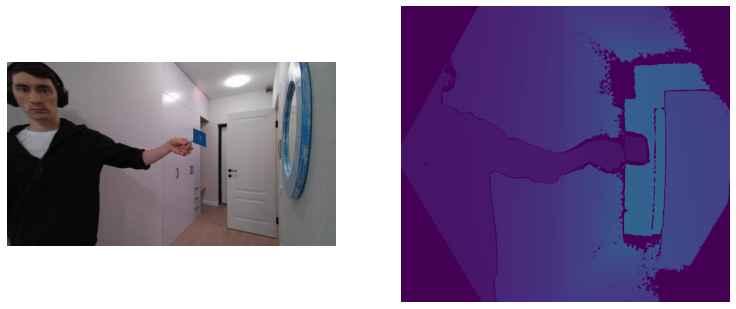

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(132)
plt.imshow(img_depth)
plt.axis("off");

### 1.1 Undistort intrinsics

In [10]:
def undistort_calibration_matrix(shape, calibration_matrix, dist_coeff):
    """
    Returns undistorted calibration matrix.
    
    : param shape : shape of image [x, y]
    : param calibration_matrix : calibration matrix [3 x 3]
    : param dist_coeff : distortions' vector
    """
    undist_calibration, _ = cv2.getOptimalNewCameraMatrix(calibration_matrix, dist_coeff, shape, 1, shape)

    return undist_calibration

In [11]:
Kc_undistorted = undistort_calibration_matrix(img_rgb.shape[:2], Kc, Dc)
Kd_undistorted = undistort_calibration_matrix(img_depth.shape, Kd, Dd)

### 1.2 Undistort images

In [12]:
def undistort_image(image, calibration_matrix, dist_coeff, undist_calibration_matrix, inter_method):
    """
    Returns undistorted image.
    
    : param image : image to undistort
    : param calibration_matrix : calibration matrix [3 x 3]
    : param dist_coeff : distortions' vector
    : param undist_calibration_matrix : undistorted calibration matrix [3 x 3]
    : param inter_method : method of interpolation
    """
    if len(image.shape) == 3:
        shape = image.shape[::-1][1:]

    elif len(image.shape) == 2:
        shape = image.shape[::-1]

    else:
        raise NotImplementedError

    map_x, map_y = cv2.initUndistortRectifyMap(calibration_matrix, dist_coeff, None, undist_calibration_matrix, shape, cv2.CV_32FC1)
    undist_image = cv2.remap(image, map_x, map_y, inter_method)

    return undist_image

In [13]:
img_rgb_undistorted = undistort_image(img_rgb, Kc, Dc, Kc_undistorted, cv2.INTER_LINEAR)
img_depth_undistorted = undistort_image(img_depth, Kd, Dd, Kd_undistorted, cv2.INTER_LINEAR)

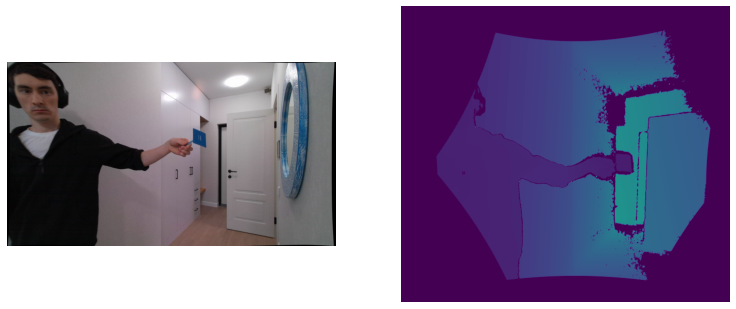

In [14]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(img_rgb_undistorted)
plt.axis("off")

plt.subplot(132)
plt.imshow(img_depth_undistorted)
plt.axis("off");

###  2 From image plane to local coordinate frame of depth camera

In [15]:
def to_homogeneous(t):
    """
    Homegenize coordinates.
    
    : param t : cartesian coordinates
    """
    return np.concatenate((t, np.ones((len(t), 1))), axis=-1)


def to_norm_image_coord(loc_kp, calibration_matrix):
    """
    : param loc_kp : np.ndarray(N, 2), points to transform
    : param calibration_matrix : calibration matrix [3 x 3]
    """
    return (np.linalg.inv(calibration_matrix) @ to_homogeneous(loc_kp).T).T


def pointcloudify_depths(img_depth, undist_calibration_matrix):
    """
    Transform from depth image frame to depth camera frame.
    
    : param img_depth : np.ndarray, depth image
    : param undist_calibration_matrix : undistorted calibration matrix [3 x 3]
    """
    shape = img_depth.shape[::-1]

    grid_x, grid_y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    grid = np.concatenate([np.expand_dims(grid_x, -1),
                           np.expand_dims(grid_y, -1)], axis=-1)

    norm_grid = to_norm_image_coord(grid.reshape(-1, 2), undist_calibration_matrix)

    # Raise by undistorted depth value from image plane to local camera space 
    local_grid = norm_grid * np.expand_dims(img_depth.reshape(-1), axis=-1)


    return local_grid.astype(np.float32)

In [16]:
local_depth_camera_pcd = pointcloudify_depths(img_depth_undistorted, Kd_undistorted)

###  3 From coordinate system of depth camera to coordinate system of rgb camera

In [17]:
def to_cartesian(t):
    """
    Dehomegenize coordinates.
    
    : param t : homogeneous coordinates
    """
    return t[:, :-1] / np.expand_dims(t[:, -1], -1)

In [18]:
local_rgb_camera_pcd = to_cartesian((T_opt @ to_homogeneous(local_depth_camera_pcd).transpose()).transpose())

### 4  Transform point cloud from rgb camera coordinate frame to rgb camera image plane and plot projected points

In [19]:
def project2image(scene_points, undistorted_calibration_matrix):
    """
    Transform point cloud from camera coordinate frame to camera image plane.
    
    : param scene_points : np.ndarray(N, 3), point cloud in camera coordinate frame
    """
    return to_cartesian((undistorted_calibration_matrix @ scene_points.T).T)


def plot_projected_pcd(image, local_scene_points, undist_calibration_matrix, key, fig_size=(18, 18), path_to_save=''):
    """
    Highlight pixels which have correspondences both in depth and rgb images and plot them over rgb image.
    
    : param image : rgb image on which to project
    : param local_scene_points : np.ndarray(N, 3), point cloud in rgb camera coordinate frame
    : param undist_calibration_matrix : undistorted calibration matrix [3 x 3]
    : param key : key of image (used as title)
    : param path_to_save : path to save figure, if given only save figure without showing it
    
    """
    h, w = image.shape[:2]

    d = np.linalg.norm(local_scene_points, axis=-1)

    proj_pcd = project2image(local_scene_points, undist_calibration_matrix)
    proj_pcd = np.round(proj_pcd).astype(int)[:, [0, 1]]

    proj_mask = (proj_pcd[:, 0] >= 0) & (proj_pcd[:, 0] < w) & (proj_pcd[:, 1] >= 0) & (proj_pcd[:, 1] < h)

    proj_pcd = proj_pcd[proj_mask, :]
    d = d[proj_mask]

    max_value = d.max() * 2

    pcd_image = np.ones((h, w)) * max_value

    pcd_image[proj_pcd[:, 1], proj_pcd[:, 0]] = d
    pcd_image = minimum_filter(pcd_image, footprint=np.ones((5, 5)))
    pcd_image[pcd_image == max_value] = 0.0

    normalize = mcolors.Normalize(vmin=np.min(pcd_image), vmax=np.max(pcd_image))
    s_map = cm.ScalarMappable(norm=normalize, cmap=cm.viridis)

    pcd_image_rgba = s_map.to_rgba(pcd_image) * (1 - np.expand_dims(pcd_image == 0.0, -1))
    
    plt.figure(figsize=fig_size)
    plt.title(key)
    plt.imshow(image)
    plt.imshow(pcd_image_rgba, alpha=0.3)
    if path_to_save:
        plt.savefig(path_to_save)
        plt.close()

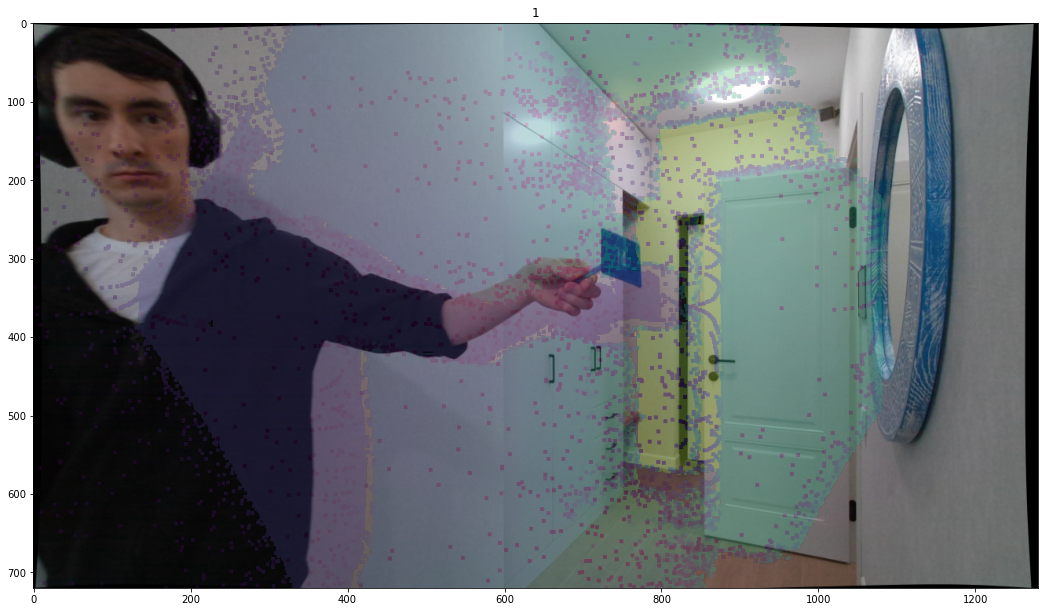

In [20]:
plot_projected_pcd(img_rgb_undistorted, local_rgb_camera_pcd, Kc_undistorted, key=1)

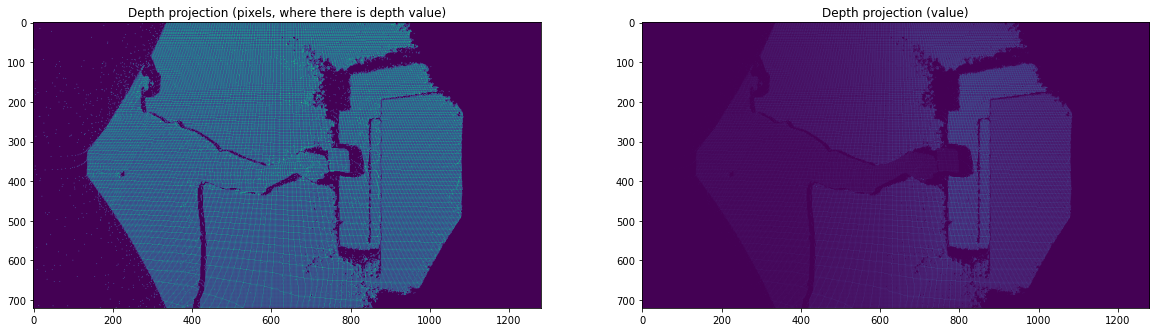

In [21]:
image = img_rgb_undistorted
local_scene_points = local_rgb_camera_pcd
undist_intrinsics = Kc_undistorted
key = 1
fig_size=(18, 18)


h, w = image.shape[:2]

depth = local_scene_points[:, 2]
proj_pcd = project2image(local_scene_points, undist_intrinsics)

proj_pcd = np.round(proj_pcd).astype(int)[:, [0, 1]]
proj_mask = (proj_pcd[:, 0] >= 0) & (proj_pcd[:, 0] < w) & (proj_pcd[:, 1] >= 0) & (proj_pcd[:, 1] < h)

proj_pcd = proj_pcd[proj_mask, :]
depth = depth[proj_mask]


pcd_image = np.zeros((h, w))
pcd_image[proj_pcd[:, 1], proj_pcd[:, 0]] = depth


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(pcd_image > 0)
plt.title('Depth projection (pixels, where there is depth value)')

plt.subplot(122)
plt.imshow(pcd_image)
plt.title('Depth projection (value)');

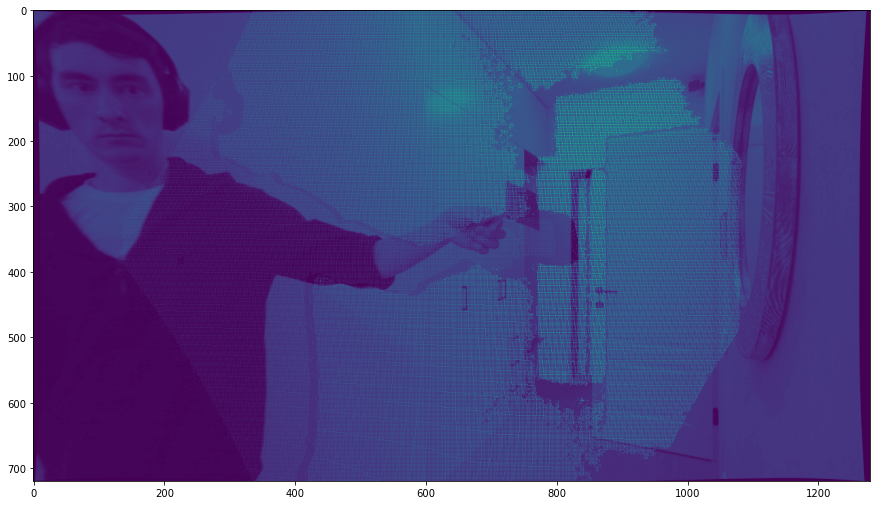

In [22]:
from skimage.color import rgb2gray

scaler = lambda x: (x - x.min()) / (x.max() - x.min())

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(0.3 * rgb2gray(image) + 0.7 * scaler(pcd_image))

# All pipeline

In [23]:
import os

def images_names_alignment(output_dir):
    
    rgb_to_depth_names_corresp = {} 
    
    path_to_rgb_images = os.listdir(output_dir + 'color/')
    path_to_depth_images = os.listdir(output_dir + 'depth/')
    
    rgb_format = path_to_rgb_images[0].rsplit('.', 1)[1]
    depth_format = path_to_depth_images[0].rsplit('.', 1)[1]
    
    rgb_timestamps = np.array([float(path.rsplit('.', 1)[0]) for path in path_to_rgb_images])
    depth_timestamps = np.array([float(path.rsplit('.', 1)[0]) for path in path_to_depth_images])
    
    for ts in rgb_timestamps:
        cor_idx = np.argmin(np.abs(ts - depth_timestamps))
        rgb_to_depth_names_corresp[f'{ts}.{rgb_format}'] = f'{depth_timestamps[cor_idx]}.{depth_format}'
    
    return rgb_to_depth_names_corresp

In [24]:
def depth2rgb(output_dir, Kc, Kd, Dc, Dd):

    rgb_to_depth_names_corresp = images_names_alignment(output_dir)
    
    path_to_rgb_dir = output_dir + 'color/'
    path_to_depth_dir = output_dir + 'depth/'
    
    for rgb_path, depth_path in rgb_to_depth_names_corresp.items():
        
        img_depth = cv2.imread(path_to_depth_dir + depth_path, cv2.IMREAD_UNCHANGED)
        img_rgb = plt.imread(path_to_rgb_dir + rgb_path)

        Kc_undistorted = undistort_calibration_matrix(img_rgb.shape[:2], Kc, Dc)
        Kd_undistorted = undistort_calibration_matrix(img_depth.shape, Kd, Dd)
        
        img_rgb_undistorted = undistort_image(img_rgb, Kc, Dc, Kc_undistorted, cv2.INTER_LINEAR)
        img_depth_undistorted = undistort_image(img_depth, Kd, Dd, Kd_undistorted, cv2.INTER_LINEAR)
        
        local_depth_camera_pcd = pointcloudify_depths(img_depth_undistorted, Kd_undistorted)
        local_rgb_camera_pcd = to_cartesian((T_opt @ to_homogeneous(local_depth_camera_pcd).transpose()).transpose())
        
        plot_projected_pcd(img_rgb_undistorted, local_rgb_camera_pcd, Kc_undistorted, key=rgb_path, path_to_save=output_dir + 'aligned/'+ rgb_path)

In [25]:
depth2rgb('./output/2022-02-24-10-26-13/1m/', Kc, Kd, Dc, Dd)

[ WARN:0@5.740] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./output/2022-02-24-10-26-13/1m/depth/100.0.png'): can't open/read file: check file path/integrity


FileNotFoundError: [Errno 2] No such file or directory: './output/2022-02-24-10-26-13/1m/color/100.0.png'